# Lab 05: Regularized linear regression

The goal of this lab is to explore and understand l1 and l2 regularization of linear models.

In [1]:
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# 1. Classification data

We will use the same data as in Lab 4: the samples are tumors, each described by the expression (= the abundance) of 3,000 genes. The goal is to separate the endometrium tumors from the uterine ones.

In [2]:
# load the endometrium vs. uterus tumor data
endometrium_data = pd.read_csv('data/small_Endometrium_Uterus.csv', sep=",")  # load data
endometrium_data.head(n=5)  # adjust n to view more data

,ID_REF,1554530_at,1553185_at,1554340_a_at,1556202_at,1553957_at,1555469_a_at,1553660_at,1554681_a_at,1554938_a_at,...,1553967_at,1553362_at,1553002_at,1556194_a_at,1556420_s_at,1555855_at,1554508_at,1555097_a_at,1556371_at,Tissue
0,117722,10.8,13233.7,27.2,167.8,450.7,283.8,6.4,8.6,26.7,...,165.2,43.7,77.0,42.2,154.8,266.6,444.0,66.9,50.6,Endometrium
1,76638,12.6,4986.8,1.7,221.1,380.8,394.3,121.2,8.0,153.8,...,190.7,3.2,84.0,183.0,288.0,20.6,99.3,6.4,12.2,Endometrium
2,88952,16.6,6053.8,121.4,342.7,217.6,367.9,159.7,10.8,124.4,...,95.9,17.1,72.3,292.9,209.5,11.6,51.3,33.8,33.4,Endometrium
3,76632,9.9,6109.1,23.0,139.3,501.8,289.9,101.7,9.7,204.8,...,235.1,37.9,81.5,109.3,537.7,58.7,73.9,58.9,15.4,Endometrium
4,88966,13.1,8430.9,17.4,29.4,449.1,248.2,104.1,11.2,94.5,...,125.0,59.9,186.8,122.5,355.2,65.1,139.9,14.1,11.2,Endometrium


In [3]:
# Create the design matrix and target vector
X_clf = endometrium_data.drop(['ID_REF', 'Tissue'], axis=1).values
y_clf = pd.get_dummies(endometrium_data['Tissue']).values[:,1]

__Question:__ Split the data in a train set containing 70% of the data and a test set containing the remaining 30%. We use [model_selection.train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split_)

In [4]:
from sklearn import model_selection
Xtr, Xte, ytr, yte = model_selection.train_test_split(X_clf, y_clf, 
                                                      test_size=0.3, 
                                                      random_state=42,
                                                      stratify=y_clf)

Let us also compute a scaled version of the data. The data is scaled on the _train_ set, and the scaling parameters (mean, standard deviation) are applied to the test set. __Question:__ Why?

In [5]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
Xtr_scaled = scaler.fit_transform(Xtr)
Xte_scaled = scaler.transform(Xte)

# 2. Logistic regression, not regularized 

Let us train a logisitic regression _without regularization_ on our train set, and evaluate it on the test set. This is similar to Lab 4 and will serve as a comparison point.

In [6]:
# Logistic regression (no regularization, no scaling)
from sklearn import linear_model
clf_logreg = linear_model.LogisticRegression(C=1e6) # large C = no regularization

# Train the model
clf_logreg.fit(Xtr, ytr)

# Predict on the test set
# Predicted probabilities of belonging to the positive class
pos_idx = list(clf_logreg.classes_).index(1)
ypred_logreg = clf_logreg.predict_proba(Xte)[:, pos_idx]

# Predicted binary labels
ypred_logreg_b = np.where(ypred_logreg > 0.5, 1, 0)

from sklearn import metrics
print("No regularization: accuracy = %.3f" % metrics.accuracy_score(yte, ypred_logreg_b))
print("AUC = %.3f" % (metrics.roc_auc_score(yte, ypred_logreg)))

No regularization: accuracy = 0.691
AUC = 0.651


/home/wbader/miniconda3/envs/tp-ml/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


__Question:__ Repeat the experiment on the scaled data. What do you observe in terms of performance?

In [7]:
# Logistic regression (no regularization, scaling)
clf_logreg_s = linear_model.LogisticRegression(C=1e6)

# Train the model
clf_logreg_s.fit(Xtr_scaled, ytr)

# Predict on the test set
# Predicted probabilities of belonging to the positive class
pos_idx = list(clf_logreg_s.classes_).index(1)
ypred_logreg_s = clf_logreg_s.predict_proba(Xte_scaled)[:, pos_idx]
# Predicted binary labels
ypred_logreg_s_b =  np.where(ypred_logreg_s > 0.5, 1, 0)

print("Scaled, no regularization: accuracy = %.3f" % metrics.accuracy_score(yte, ypred_logreg_s_b))
print("AUC = %.3f" % (metrics.roc_auc_score(yte, ypred_logreg_s)))

Scaled, no regularization: accuracy = 0.691
AUC = 0.784


# 3. L2-regularized logistic regression 

__Question:__ What is the role of L2 regularization?

Let us use an l2-regularized logistic regression with the parameter `C` set to 0.01. 

__Question:__ What is the role of `C`? How does it relate to the `lambda` regularization parameter we have seen in class?

__Question:__ Train the l2-regularized logistic regression initialized below on the scaled training data, and evaluate it on the sclaed test set (as above). How does the performance evolve?

In [8]:
cvalue = 0.01
clf_logreg_l2_s = linear_model.LogisticRegression(C=cvalue, penalty='l2')

# Train the model
clf_logreg_l2_s.fit(Xtr_scaled, ytr)

# index of positive class
pos_idx = list(clf_logreg_l2_s.classes_).index(1)
# predict probability of being positive
ypred_logreg_l2_s = clf_logreg_l2_s.predict_proba(Xte_scaled)[:, pos_idx]
# predict binary labels
ypred_logreg_l2_s_b = np.where(ypred_logreg_l2_s > 0.5, 1, 0)

print("Scaled, l2 regularization (C=%.2e): accuracy = %.3f" % (cvalue, 
                                                               metrics.accuracy_score(yte, ypred_logreg_l2_s_b)))
print("AUC = %.3f" % (metrics.roc_auc_score(yte, ypred_logreg_l2_s)))

Scaled, l2 regularization (C=1.00e-02): accuracy = 0.727
AUC = 0.817


### 3.1 Effect of L2-regularization on the logistic regression coefficients

We will now look at how the regression coefficients have evolved between the non-regularized and the regularized versions of the logistic regression.

__Question:__ Fill in the blanks below to plot the regression coefficients of both the trained `clf_logreg_l2_s` and `clf_logreg_s` models. Use the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) to figure out how to access these coefficients. What do you observe?

(0.0, 3000.0)

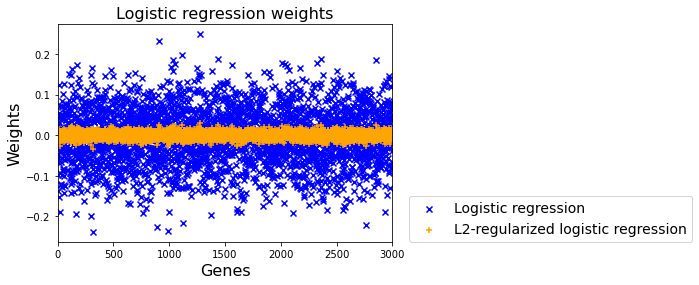

In [9]:
# Effect of l2-regularization on the weights
num_features = X_clf.shape[1]
plt.scatter(range(num_features), clf_logreg_s.coef_, 
            color='blue', marker='x', label='Logistic regression')
plt.scatter(range(num_features), clf_logreg_l2_s.coef_, 
            color='orange', marker='+', label='L2-regularized logistic regression')

plt.xlabel('Genes', fontsize=16)
plt.ylabel('Weights', fontsize=16)
plt.title('Logistic regression weights', fontsize=16)
plt.legend(fontsize=14, loc=(1.05, 0))
plt.xlim([0, num_features])

## 3.2 Optimization of the regularization parameter

We will now use a 3-fold cross-validation on the training set to optimize the value of C. Scikit-learn makes it really easy to use a cross-validation to choose a good value for $\alpha$ among a grid of several choices. Check the [GridSearchCV class](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html#sklearn.grid_search.GridSearchCV).

In [10]:
# Create a range of values to test for the parameter C
cvalues_list = np.logspace(-5, 1, 20)
print(cvalues_list)

[1.00000000e-05 2.06913808e-05 4.28133240e-05 8.85866790e-05
 1.83298071e-04 3.79269019e-04 7.84759970e-04 1.62377674e-03
 3.35981829e-03 6.95192796e-03 1.43844989e-02 2.97635144e-02
 6.15848211e-02 1.27427499e-01 2.63665090e-01 5.45559478e-01
 1.12883789e+00 2.33572147e+00 4.83293024e+00 1.00000000e+01]


__Question:__ Fill in the blanks below to find the optimal value of the parameter C.

Use the `.best_estimator_` attribute of a `GridSearchCV`. 

In [11]:
# Optimize cvalue
classifier = linear_model.LogisticRegression(penalty='l2')
param_grid = {'C': cvalues_list
             }
clf_logreg_l2_s_opt = model_selection.GridSearchCV(classifier, 
                                                   param_grid, 
                                                   cv=3)     

# Train the model
clf_logreg_l2_s_opt.fit(Xtr_scaled, ytr)

# index of positive class
pos_idx = list(clf_logreg_l2_s_opt.best_estimator_.classes_).index(1)
# predict probability of being positive
ypred_logreg_l2_s_opt = clf_logreg_l2_s_opt.best_estimator_.predict_proba(Xte_scaled)[:, pos_idx]
# predict binary label
ypred_logreg_l2_s_opt_b = np.where(ypred_logreg_l2_s_opt > 0.5, 1, 0)

# optimal value of C
cvalue_opt = clf_logreg_l2_s_opt.best_params_['C']
print("Scaled, l2 regularization (C=%.2e): accuracy = %.3f" % (cvalue_opt, 
                                                               metrics.accuracy_score(yte, ypred_logreg_l2_s_opt_b)))
print("AUC = %.3f" % (metrics.roc_auc_score(yte, ypred_logreg_l2_s_opt)))

Scaled, l2 regularization (C=5.46e-01): accuracy = 0.709
AUC = 0.806


__Question:__ Fill in the code below to compare the ROC curves of the non-regularized and l2-regularized logistic regressions.

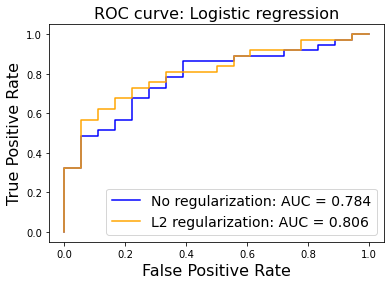

In [12]:
fpr_logreg_s, tpr_logreg_s, t = metrics.roc_curve(yte, ypred_logreg_s , pos_label=1)
auc_logreg_s = metrics.auc(fpr_logreg_s, tpr_logreg_s)
plt.plot(fpr_logreg_s, tpr_logreg_s, color='blue', 
         label='No regularization: AUC = %0.3f' % auc_logreg_s)

fpr_logreg_l2_s_opt, tpr_logreg_l2_s_opt, t = metrics.roc_curve(yte, ypred_logreg_l2_s_opt , pos_label=1)
auc_logreg_l2_s_opt = metrics.auc(fpr_logreg_l2_s_opt, tpr_logreg_l2_s_opt)
plt.plot(fpr_logreg_l2_s_opt, tpr_logreg_l2_s_opt, color='orange', 
         label='L2 regularization: AUC = %0.3f' % auc_logreg_l2_s_opt)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve: Logistic regression', fontsize=16)
plt.legend(fontsize=14)

__Question:__ Is the optimal C larger or smaller than the one we tried before? Does this mean more or less regularization? Do you expect larger or smaller regularization coefficients?

__Question:__ Fill in the blanks to compare the regularization weights of the different methods.

(0.0, 3000.0)

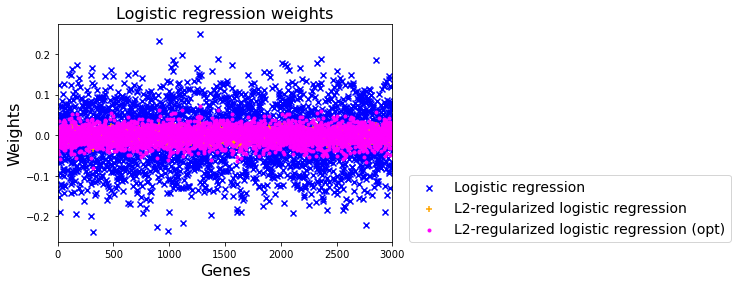

In [13]:
# Effect of l2-regularization on the weights
num_features = X_clf.shape[1]
plt.scatter(range(num_features), clf_logreg_s.coef_, 
            color='blue', marker='x', label='Logistic regression')
plt.scatter(range(num_features), clf_logreg_l2_s.coef_, 
            color='orange', marker='+', label='L2-regularized logistic regression')
plt.scatter(range(num_features), clf_logreg_l2_s_opt.best_estimator_.coef_, 
            color='magenta', marker='.', label='L2-regularized logistic regression (opt)')

plt.xlabel('Genes', fontsize=16)
plt.ylabel('Weights', fontsize=16)
plt.title('Logistic regression weights', fontsize=16)
plt.legend(fontsize=14, loc=(1.05, 0))
plt.xlim([0, num_features])

# 4. L1-regularized logistic regression

__Question:__ What is the role of the l1-regularized logistic regression?

__Question:__ Instead of a l2-regularized logistic regression with `C=0.01`, now train and evaluate a __l1__-regularized logistic regression with __`C=10.0`__.

In [14]:
cvalue = 10
clf_logreg_l1_s = linear_model.LogisticRegression(C=cvalue, penalty='l1' ,solver='liblinear')
clf_logreg_l1_s.fit(Xtr_scaled, ytr)

# index of the positive class
pos_idx = list(clf_logreg_l1_s.classes_).index(1)
# predict the probability of belonging to the positive class
ypred_logreg_l1_s = clf_logreg_l1_s.predict_proba(Xte_scaled)[:, pos_idx]
# predict binary labels
ypred_logreg_l1_s_b = np.where(ypred_logreg_l1_s > 0.5, 1, 0)

print("Scaled, l1 regularization (C=%.2e): accuracy = %.3f" % (cvalue, 
                                                               metrics.accuracy_score(yte, ypred_logreg_l1_s_b)))
print("AUC = %.3f" % (metrics.roc_auc_score(yte, ypred_logreg_l1_s)))

Scaled, l1 regularization (C=1.00e+01): accuracy = 0.709
AUC = 0.757


__Question__: How did the performance evolve?

## 4.1 Effect of regularization on the regression coefficients

__Question:__ Plot the weights that were given to each feature in your data.

(0.0, 3000.0)

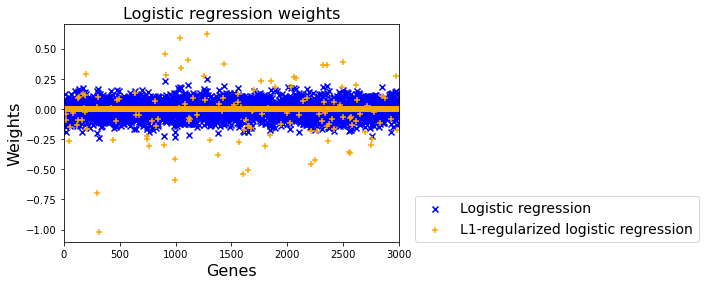

In [15]:
num_features = X_clf.shape[1]
plt.scatter(range(num_features), clf_logreg_s.coef_, 
            color='blue', marker='x', label='Logistic regression')
plt.scatter(range(num_features),  clf_logreg_l1_s.coef_, 
            color='orange', marker='+', label='L1-regularized logistic regression')

plt.xlabel('Genes', fontsize=16)
plt.ylabel('Weights', fontsize=16)
plt.title('Logistic regression weights', fontsize=16)
plt.legend(fontsize=14, loc=(1.05, 0))
plt.xlim([0, num_features])

__Question:__ What do you observe? How does this differ from l2-regularization?

__Question:__ How many weights are different from zero? How many features are _not_ used by the l1-regularized model? 

In [16]:
# Number of selected features
print("The non-regularized logistic regression uses %d features" % len(np.where(clf_logreg_s.coef_ !=0)[1]))
print("The L2-regularized logistic regression uses %d features" % sum(clf_logreg_l2_s.coef_!=0)
     )
print("The L1-regularized logistic regression uses %d features" % sum(clf_logreg_l1_s.coef_!=0)
     )

print("Number of features discarded by the L1-regularization: %d" % sum(clf_logreg_l1_s.coef_ == 0))

The non-regularized logistic regression uses 3000 features
The L2-regularized logistic regression uses 3000 features
The L1-regularized logistic regression uses 138 features
Number of features discarded by the L1-regularization: 2862


## 4.2 Optimization of the regularization parameter

__Question:__ Fill in the blanks to optimize the value of `C` for l1-regularized logistic regression.

In [17]:
# Optimize cvalue
cvalues_list = np.logspace(-2, 3, 20)
print(cvalues_list)

classifier = linear_model.LogisticRegression(penalty='l1',solver='liblinear')
param_grid = {'C': cvalues_list
             }
clf_logreg_l1_s_opt = model_selection.GridSearchCV(classifier, 
                                                   param_grid, 
                                                   cv=3)  
# Train the model
clf_logreg_l1_s_opt.fit(Xtr_scaled, ytr)

# index of positive class
pos_idx = list(clf_logreg_l1_s_opt.best_estimator_.classes_).index(1)
# predict probability of being positive
ypred_logreg_l1_s_opt = clf_logreg_l1_s_opt.best_estimator_.predict_proba(Xte_scaled)[:, pos_idx]
# predict binary label
ypred_logreg_l1_s_opt_b = np.where(ypred_logreg_l1_s_opt > 0.5, 1, 0)

# optimal value of C
cvalue_opt = clf_logreg_l1_s_opt.best_params_['C'];

print("Scaled, l1 regularization (C=%.2e): accuracy = %.3f" % (cvalue_opt, 
                                                               metrics.accuracy_score(yte, ypred_logreg_l1_s_b)))
print("AUC = %.3f" % (metrics.roc_auc_score(yte, ypred_logreg_l1_s_opt)))

[1.00000000e-02 1.83298071e-02 3.35981829e-02 6.15848211e-02
 1.12883789e-01 2.06913808e-01 3.79269019e-01 6.95192796e-01
 1.27427499e+00 2.33572147e+00 4.28133240e+00 7.84759970e+00
 1.43844989e+01 2.63665090e+01 4.83293024e+01 8.85866790e+01
 1.62377674e+02 2.97635144e+02 5.45559478e+02 1.00000000e+03]
Scaled, l1 regularization (C=4.83e+01): accuracy = 0.709
AUC = 0.760


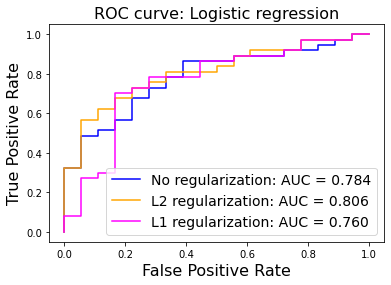

In [18]:
# ROC curve
fpr_logreg_s, tpr_logreg_s, t = metrics.roc_curve(yte, ypred_logreg_s , pos_label=1)
auc_logreg_s = metrics.auc(fpr_logreg_s, tpr_logreg_s)
plt.plot(fpr_logreg_s, tpr_logreg_s, color='blue', 
         label='No regularization: AUC = %0.3f' % auc_logreg_s)

fpr_logreg_l2_s_opt, tpr_logreg_l2_s_opt, t = metrics.roc_curve(yte, ypred_logreg_l2_s_opt , pos_label=1)
auc_logreg_l2_s_opt = metrics.auc(fpr_logreg_l2_s_opt, tpr_logreg_l2_s_opt)
plt.plot(fpr_logreg_l2_s_opt, tpr_logreg_l2_s_opt, color='orange', 
         label='L2 regularization: AUC = %0.3f' % auc_logreg_l2_s_opt)

fpr_logreg_l1_s_opt, tpr_logreg_l1_s_opt, t = metrics.roc_curve(yte, ypred_logreg_l1_s_opt, pos_label=1)
auc_logreg_l1_s_opt = metrics.auc(fpr_logreg_l1_s_opt, tpr_logreg_l1_s_opt)
plt.plot(fpr_logreg_l1_s_opt, tpr_logreg_l1_s_opt, color='magenta', 
         label='L1 regularization: AUC = %0.3f' % auc_logreg_l1_s_opt)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve: Logistic regression', fontsize=16)
plt.legend(fontsize=14)

__Question:__ How many genes does the l1-regularized approach select? How does this affect the performance, compared to `C=10.0` or the l2-regularized approach?

In [19]:
print("The L1-regularized logistic regression uses %d features" % sum(clf_logreg_l1_s.coef_!=0)
     )
print("The optimized L1-regularized logistic regression uses %d features" % \
      sum(clf_logreg_l1_s_opt.best_estimator_.coef_!=0)
     )

The L1-regularized logistic regression uses 138 features
The optimized L1-regularized logistic regression uses 153 features


__Question:__ Compare the features selected with `C=0.01` and your optimal `C` value. What do you observe?

(0.0, 3000.0)

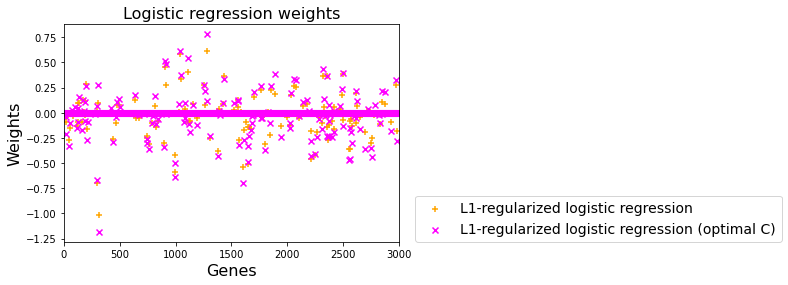

In [20]:
num_features = X_clf.shape[1]
plt.scatter(range(num_features), clf_logreg_l1_s.coef_, 
            color='orange', marker='+', label='L1-regularized logistic regression')
plt.scatter(range(num_features), clf_logreg_l1_s_opt.best_estimator_.coef_, 
            color='magenta', marker='x', label='L1-regularized logistic regression (optimal C)')

plt.xlabel('Genes', fontsize=16)
plt.ylabel('Weights', fontsize=16)
plt.title('Logistic regression weights', fontsize=16)
plt.legend(fontsize=14, loc=(1.05, 0))
plt.xlim([0, num_features])